In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import jax
import jax.numpy as jnp
import jax_cosmo as jc
from jaxdecomp import ShardedArray
import matplotlib.pyplot as plt
import numpy as np
from jaxpm.distributed import normal_field
from lensing_model import make_full_field_model


os.environ["EQX_ON_ERROR"] = "nan"
jax.config.update("jax_enable_x64", True)

/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

os.makedirs("plots", exist_ok=True)
os.makedirs("data", exist_ok=True)

In [3]:
box_shape = (64, 64, 128)
box_size = [200.0, 200.0, 400.0]
field_size = 16.0  # transverse size in degrees
field_npix = 64  # number of pixels per side
density_plane_width = 100
density_plane_npix = 300
density_plane_smoothing = 0.1

forward_model = make_full_field_model(
    field_size=field_size,
    field_npix=field_npix,
    box_shape=box_shape,
    box_size=box_size,
    density_plane_width=density_plane_width,
    density_plane_npix=density_plane_npix,
    density_plane_smoothing=density_plane_smoothing,
    adjoint="reverse"
)

In [4]:
from scipy.stats import norm

z = jnp.linspace(0, 2.5, 1000)

nz_shear = [
    jc.redshift.kde_nz(
        z, norm.pdf(z, loc=z_center, scale=0.12), bw=0.01, zmax=2.5, gals_per_arcmin2=g
    )
    for z_center, g in zip([0.5, 1.0, 1.5, 2.0], [7, 8.5, 7.5, 7])
]
nbins = len(nz_shear)

# Define the fiducial cosmology
Omega_b = 0.049
Omega_c = 0.315 - Omega_b
sigma_8 = 0.8
h = 0.677
n_s = 0.9624
w0 = -1
cosmo = jc.Cosmology(
    Omega_c=Omega_c,
    sigma8=sigma_8,
    Omega_b=Omega_b,
    h=h,
    n_s=n_s,
    w0=w0,
    Omega_k=0.0,
    wa=0.0,
)

# Specify the size and resolution of the patch to simulate
sigma_e = 0.3
print("Pixel size in arcmin: ", field_size * 60 / field_npix)

Pixel size in arcmin:  15.0


Text(0.5, 1.0, 'Redshift distribution')

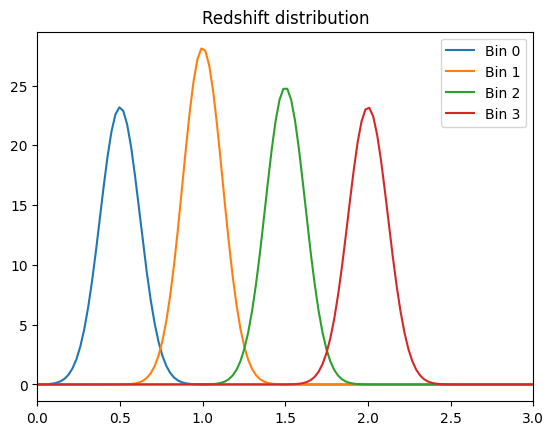

In [5]:
# Plotting the redshift distribution
z = np.linspace(0, 3.0, 128)

for i in range(nbins):
    plt.plot(
        z,
        nz_shear[i](z) * nz_shear[i].gals_per_arcmin2,
        color="C%d" % i,
        label="Bin %d" % i,
    )
plt.legend()
plt.xlim(0, 3)
plt.title("Redshift distribution")

In [6]:
initial_conditions = normal_field(box_shape, seed=jax.random.key(0))
initial_conditions = ShardedArray(initial_conditions)
kappas, lc = forward_model(cosmo, nz_shear, initial_conditions)

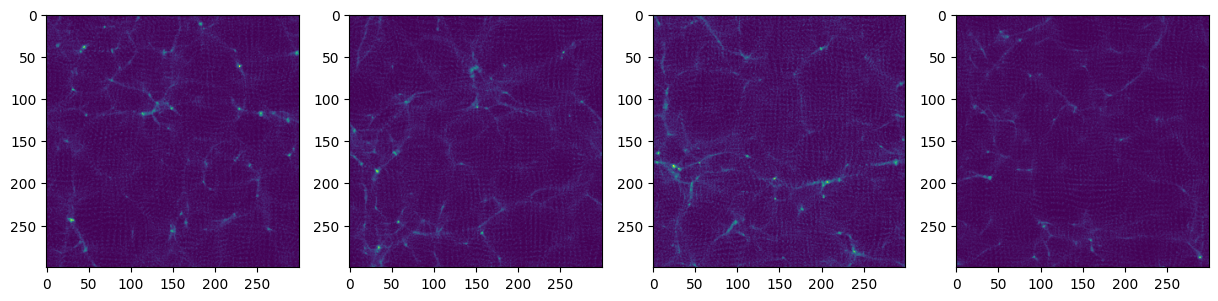

In [7]:
plt.figure(figsize=(15, 5))
for i in range(nbins):
    plt.subplot(1, nbins, i + 1)
    plt.imshow(lc[..., i].data)

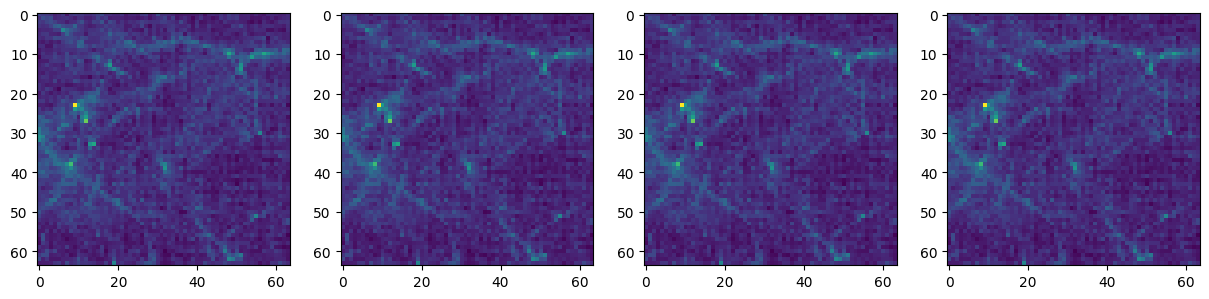

In [8]:
plt.figure(figsize=(15, 5))
for i in range(nbins):
    plt.subplot(1, nbins, i + 1)
    plt.imshow(kappas[i])

In [9]:
def model(cosmo , nz_shear, initial_conditions):
    kappas, _ = forward_model(cosmo, nz_shear, initial_conditions)
    return jnp.mean(jax.tree.reduce(sum , kappas))

In [10]:
model(cosmo, nz_shear, initial_conditions)

Array(57.85161582, dtype=float64)

In [12]:
gr_rev = jax.grad(model,argnums=2)(cosmo, nz_shear, initial_conditions)

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

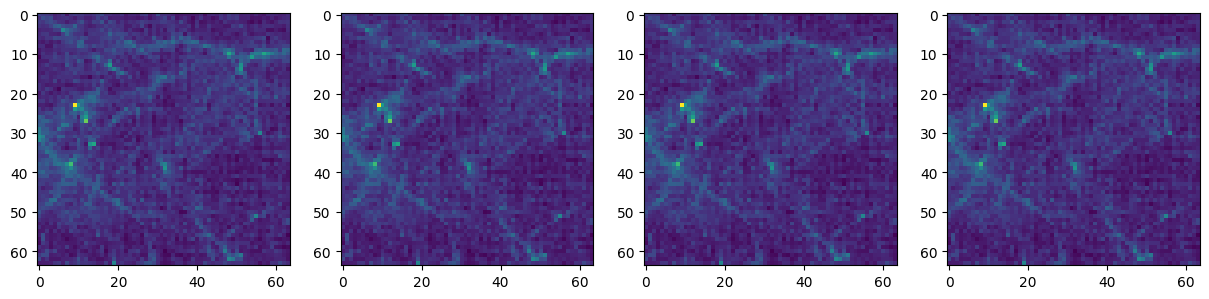